In [1]:
import matplotlib.pyplot as plt

import nest


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: Nov  6 2022 20:23:54

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Create and record from a single neuron
A neural network in NEST consists of two basic element types: nodes and connections. Nodes are either neurons, devices or sub-networks. Devices are used to stimulate neurons or to record from them. New nodes are created with the command **Create()**, which takes as arguments the model name of the desired node type, and optionally the number of nodes to be created and the initialising parameters. The function returns a NodeCollection of handles to the new nodes, which you can assign to a variable for later use. A NodeCollection is a compact representation of the node handles, which are integer numbers, called ids. Many PyNEST functions expect or return a NodeCollection (see command overview). Thus, it is easy to apply functions to large sets of nodes with a single function call.

Here, we create a simple integrate-and-fire neuron with alpha-shaped postsynaptic currents.

In [2]:
# Create a neuron
neuron = nest.Create('iaf_psc_alpha')
neuron.get()

{'archiver_length': 0,
 'beta_Ca': 0.001,
 'C_m': 250.0,
 'Ca': 0.0,
 'E_L': -70.0,
 'element_type': 'neuron',
 'frozen': False,
 'global_id': 1,
 'I_e': 0.0,
 'local': True,
 'model': 'iaf_psc_alpha',
 'model_id': 17,
 'node_uses_wfr': False,
 'post_trace': 0.0,
 'recordables': ('I_syn_ex', 'I_syn_in', 'V_m'),
 'synaptic_elements': {},
 't_ref': 2.0,
 't_spike': -1.0,
 'tau_Ca': 10000.0,
 'tau_m': 10.0,
 'tau_minus': 20.0,
 'tau_minus_triplet': 110.0,
 'tau_syn_ex': 2.0,
 'tau_syn_in': 2.0,
 'thread': 0,
 'thread_local_id': -1,
 'V_m': -70.0,
 'V_min': -inf,
 'V_reset': -70.0,
 'V_th': -55.0,
 'vp': 0}

In [3]:
# Input external current to the neuron
neuron.set(I_e=376.)

In [4]:
# Create devices (a multimeter and a spike recorder)
multimeter = nest.Create('multimeter')
multimeter.set(record_from=['V_m'])

spikerecorder = nest.Create('spike_recorder')

In [5]:
# Connect the multimeter to the neuron and the neuron to the spike recorder
# (note that the order here matters)
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spikerecorder)

# Run simulation for 1000 ms
nest.Simulate(1000.)


Jan 26 14:25:22 NodeManager::prepare_nodes [Info]: 
    Preparing 3 nodes for simulation.

Jan 26 14:25:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jan 26 14:25:22 SimulationManager::run [Info]: 
    Simulation finished.


In [6]:
# Get membrane potential of the neuron over time from the multimeter
data = multimeter.get('events')
Vm = data['V_m']
t = data['times']

# Get spike recordings of the neuron over time from the spike recorder
spike_data = spikerecorder.get('events')
spikes = spike_data['senders']
times = spike_data['times']

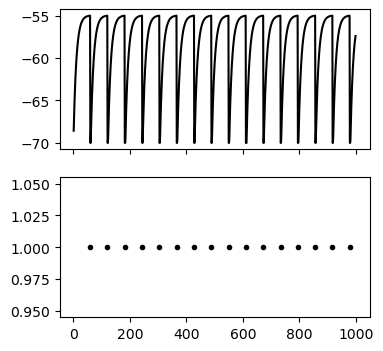

In [7]:
# Plot output of the multimeter and the spike recorder
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(4,4), sharex=True)

ax1.plot(t, Vm, c='black')
ax2.plot(times, spikes, '.', c='black')
plt.show()

In [9]:
spikerecorder.get()

{'element_type': 'recorder',
 'events': {'senders': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'times': array([ 59.3, 120.6, 181.9, 243.2, 304.5, 365.8, 427.1, 488.4, 549.7,
         611. , 672.3, 733.6, 794.9, 856.2, 917.5, 978.8])},
 'frozen': False,
 'global_id': 3,
 'label': '',
 'local': True,
 'model': 'spike_recorder',
 'model_id': 56,
 'n_events': 16,
 'node_uses_wfr': False,
 'origin': 0.0,
 'record_to': 'memory',
 'start': 0.0,
 'stop': 1.7976931348623157e+308,
 'thread': 0,
 'thread_local_id': 2,
 'time_in_steps': False,
 'vp': 0}

A commonly used model of neural activity is the Poisson process. We now adapt the previous example so that one of the neurons receives 2 Poisson spike trains, one excitatory and the other inhibitory. A Poisson spike train is a type of stochastic process that describes the firing of a neuron, where the number of action potentials (or spikes) emitted by the neuron in a given time interval follows a Poisson distribution. In other words, it describes the random timing of spikes with a fixed average rate. For this, we need a new device, the poisson_generator. After creating the neurons, we create these two generators and set their rates to 80000Hz and 15000Hz, respectively.

In [8]:
# Create a neuron with no input current
neuron = nest.Create('iaf_psc_alpha')

In [9]:
# Create excitatory and inhibitory poisson spike generators
# Note that here, the excitatory generator is set at a much higher spike rate than the inhibitory generator
noise_ex = nest.Create('poisson_generator')
noise_in = nest.Create('poisson_generator')
noise_ex.set(rate=80000.0)
noise_in.set(rate=15000.0)

Each event of the excitatory generator should produce a postsynaptic current of 1.2pA amplitude, an inhibitory event of -2.0pA. The synaptic weights can be defined in a dictionary, which is passed to the **Connect()** function using the keyword syn_spec (synapse specifications). In general all parameters determining the synapse can be specified in the synapse dictionary, such as "weight", "delay", the synaptic model ("synapse_model") and parameters specific to the synaptic model.

In [10]:
syn_dict_ex = {'weight': 1.2}
syn_dict_in = {'weight': -2.0}
nest.Connect(noise_ex, neuron, syn_spec=syn_dict_ex)
nest.Connect(noise_in, neuron, syn_spec=syn_dict_in)

In [11]:
# Create devices (a multimeter and a spike recorder)
multimeter = nest.Create('multimeter')
multimeter.set(record_from=['V_m'])

spikerecorder = nest.Create('spike_recorder')

In [12]:
# Connect the multimeter to the neuron and the neuron to the spike recorder
# (note that the order here matters)
nest.Connect(multimeter, neuron)
nest.Connect(neuron, spikerecorder)

# Run simulation for 1000 ms
nest.Simulate(1000.)


Jan 25 17:43:58 NodeManager::prepare_nodes [Info]: 
    Preparing 8 nodes for simulation.

Jan 25 17:43:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Jan 25 17:43:58 SimulationManager::run [Info]: 
    Simulation finished.


In [13]:
# Get membrane potential of the neuron over time from the multimeter
data = multimeter.get('events')
Vm = data['V_m']
t = data['times']

# Get spike recordings of the neuron over time from the spike recorder
spike_data = spikerecorder.get('events')
spikes = spike_data['senders']
times = spike_data['times']

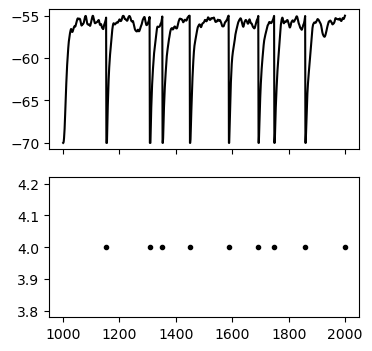

In [14]:
# Plot output of the multimeter and the spike recorder
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(4,4), sharex=True)

ax1.plot(t, Vm, c='black')
ax2.plot(times, spikes, '.', c='black')
plt.show()